Each sample in the train and test set has the following information:

- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

We are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.


More details about the competition here:
https://www.kaggle.com/c/nlp-getting-started

In [1]:
from IPython.core.debugger import set_trace

%load_ext nb_black

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="seaborn")
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
train = pd.read_csv(f"data/train.csv")
test = pd.read_csv(f"data/test.csv")

<IPython.core.display.Javascript object>

In [3]:
train.head().T

0  \
id                                                        1   
keyword                                                 NaN   
location                                                NaN   
text      Our Deeds are the Reason of this #earthquake M...   
target                                                    1   

                                               1  \
id                                             4   
keyword                                      NaN   
location                                     NaN   
text      Forest fire near La Ronge Sask. Canada   
target                                         1   

                                                          2  \
id                                                        5   
keyword                                                 NaN   
location                                                NaN   
text      All residents asked to 'shelter in place' are ...   
target                                                    1   

                                                          3  \
id                                                        6   
keyword                                                 NaN   
location                                                NaN   
text      13,000 people receive #wildfires evacuation or...   
target                                                    1   

                                                          4  
id                                                        7  
keyword                                                 NaN  
location                                                NaN  
text      Just got sent this photo from Ruby #Alaska as ...  
target                                                    1

<IPython.core.display.Javascript object>

In [4]:
test.head().T

0  \
id                                         0   
keyword                                  NaN   
location                                 NaN   
text      Just happened a terrible car crash   

                                                          1  \
id                                                        2   
keyword                                                 NaN   
location                                                NaN   
text      Heard about #earthquake is different cities, s...   

                                                          2  \
id                                                        3   
keyword                                                 NaN   
location                                                NaN   
text      there is a forest fire at spot pond, geese are...   

                                                 3  \
id                                               9   
keyword                                        NaN   
location                                       NaN   
text      Apocalypse lighting. #Spokane #wildfires   

                                                      4  
id                                                   11  
keyword                                             NaN  
location                                            NaN  
text      Typhoon Soudelor kills 28 in China and Taiwan

<IPython.core.display.Javascript object>

First we're going to clean the text data.

Remove URLs and HTML

In [5]:
import re


def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)


def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

<IPython.core.display.Javascript object>

In [6]:
def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

<IPython.core.display.Javascript object>

Remove punctuation

In [7]:
import string

<IPython.core.display.Javascript object>

In [8]:
def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

<IPython.core.display.Javascript object>

In [9]:
train["text"] = train.text.map(lambda x: remove_URL(x))
train["text"] = train.text.map(lambda x: remove_html(x))
train["text"] = train.text.map(lambda x: remove_emoji(x))
train["text"] = train.text.map(lambda x: remove_punct(x))

<IPython.core.display.Javascript object>

Remove stopwords

In [10]:
from nltk.corpus import stopwords

stop = set(stopwords.words("english"))


def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]

    return " ".join(text)

<IPython.core.display.Javascript object>

In [11]:
train["text"] = train["text"].map(remove_stopwords)

<IPython.core.display.Javascript object>

Stemming. Bundling together words of same root.


In [12]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()


def stemming(text):
    text = [stemmer.stem(word) for word in text.split()]

    return " ".join(text)

<IPython.core.display.Javascript object>

In [13]:
# train["text"] = train["text"].map(stemming)

<IPython.core.display.Javascript object>

#### Tokenization

In [14]:
from nltk.tokenize import TreebankWordTokenizer

tokenizer = TreebankWordTokenizer()

train["tokens"] = train["text"].map(tokenizer.tokenize)

<IPython.core.display.Javascript object>

In [15]:
train[["text", "tokens"]].head(10)

text  \
0       deeds reason earthquake may allah forgive us   
1              forest fire near la ronge sask canada   
2  residents asked shelter place notified officer...   
3  13000 people receive wildfires evacuation orde...   
4  got sent photo ruby alaska smoke wildfires pou...   
5  rockyfire update california hwy 20 closed dire...   
6  flood disaster heavy rain causes flash floodin...   
7                         im top hill see fire woods   
8  theres emergency evacuation happening building...   
9                      im afraid tornado coming area   

                                              tokens  
0  [deeds, reason, earthquake, may, allah, forgiv...  
1      [forest, fire, near, la, ronge, sask, canada]  
2  [residents, asked, shelter, place, notified, o...  
3  [13000, people, receive, wildfires, evacuation...  
4  [got, sent, photo, ruby, alaska, smoke, wildfi...  
5  [rockyfire, update, california, hwy, 20, close...  
6  [flood, disaster, heavy, rain, causes, flash, ...  
7                  [im, top, hill, see, fire, woods]  
8  [theres, emergency, evacuation, happening, bui...  
9                [im, afraid, tornado, coming, area]

<IPython.core.display.Javascript object>

### Bag of words

#### Counts

A bag of words just associates an index to each word in the vocabulary, and embeds each sentence as a list of 0s, with a 1 at each index corresponding to a word present in the sentence.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer


def count_vect(data, ngrams=(1, 1)):
    count_vectorizer = CountVectorizer(ngram_range=ngrams)
    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

<IPython.core.display.Javascript object>

In [42]:
train_counts, count_vectorizer = count_vect(train["text"])
test_counts = count_vectorizer.transform(test["text"])

<IPython.core.display.Javascript object>

Test to see if CountVectorizer worked as expected

In [18]:
train.shape

(7613, 6)

<IPython.core.display.Javascript object>

In [19]:
train_counts.todense().shape

(7613, 17714)

<IPython.core.display.Javascript object>

In [20]:
len(train_counts.todense()[0].tolist()[0])

17714

<IPython.core.display.Javascript object>

In [21]:
train.text.iloc[0]

'deeds reason earthquake may allah forgive us'

<IPython.core.display.Javascript object>

In [22]:
print(train_counts.todense()[0][0:].sum())

7


<IPython.core.display.Javascript object>

In [53]:
train_counts, count_vectorizer = count_vect(train["text"], ngrams=(1, 1))
test_counts = count_vectorizer.transform(test["text"])

print(train_counts.todense()[0][0:].sum())

7


<IPython.core.display.Javascript object>

#### TF IDF

Downweighting frequently occuring words in the feature vectors. Frequently occuring words typically don't contain useful information therefore TF - IDF is great for assessing word relevancy.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer


def tfidf(data, ngrams=(1, 1)):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngrams)
    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer


train_tfidf, tfidf_vectorizer = tfidf(train["text"])
test_tfidf = tfidf_vectorizer.transform(test["text"])

<IPython.core.display.Javascript object>

Test to see if TfidfVectorizer worked as expected

In [25]:
[x for x in train_tfidf.todense()[0][0:].tolist()[0] if x != 0]

[0.40602120282994786,
 0.47004586769653584,
 0.3260376260282067,
 0.47004586769653584,
 0.29098037199188415,
 0.3665665825282048,
 0.26061346373181266]

<IPython.core.display.Javascript object>

In [26]:
print(train_tfidf.todense()[0][0:].sum())

2.590310982503128


<IPython.core.display.Javascript object>

In [54]:
train_tfidf, tfidf_vectorizer = tfidf(train["text"], ngrams=(1, 1))
test_tfidf = tfidf_vectorizer.transform(test["text"])

print(train_tfidf.todense()[0][0:].sum())

2.590310982503128


<IPython.core.display.Javascript object>

#### Visualizing the embeddings


In [56]:
X_counts = train_counts
X_tfidf = train_tfidf
y = train["target"].values

<IPython.core.display.Javascript object>

Dimensionality reduction using truncated SVD (aka LSA).

This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). 

Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently.

Method from: https://www.kaggle.com/vbmokin/nlp-eda-bag-of-wc-tf-idf-glove

In [55]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label: idx for idx, label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ["orange", "blue", "blue"]
    if plot:
        plt.scatter(
            lsa_scores[:, 0],
            lsa_scores[:, 1],
            s=8,
            alpha=0.8,
            c=test_labels,
            cmap=matplotlib.colors.ListedColormap(colors),
        )
        red_patch = mpatches.Patch(color="orange", label="Irrelevant")
        green_patch = mpatches.Patch(color="blue", label="Disaster")
        plt.legend(handles=[red_patch, green_patch], prop={"size": 16})


<IPython.core.display.Javascript object>

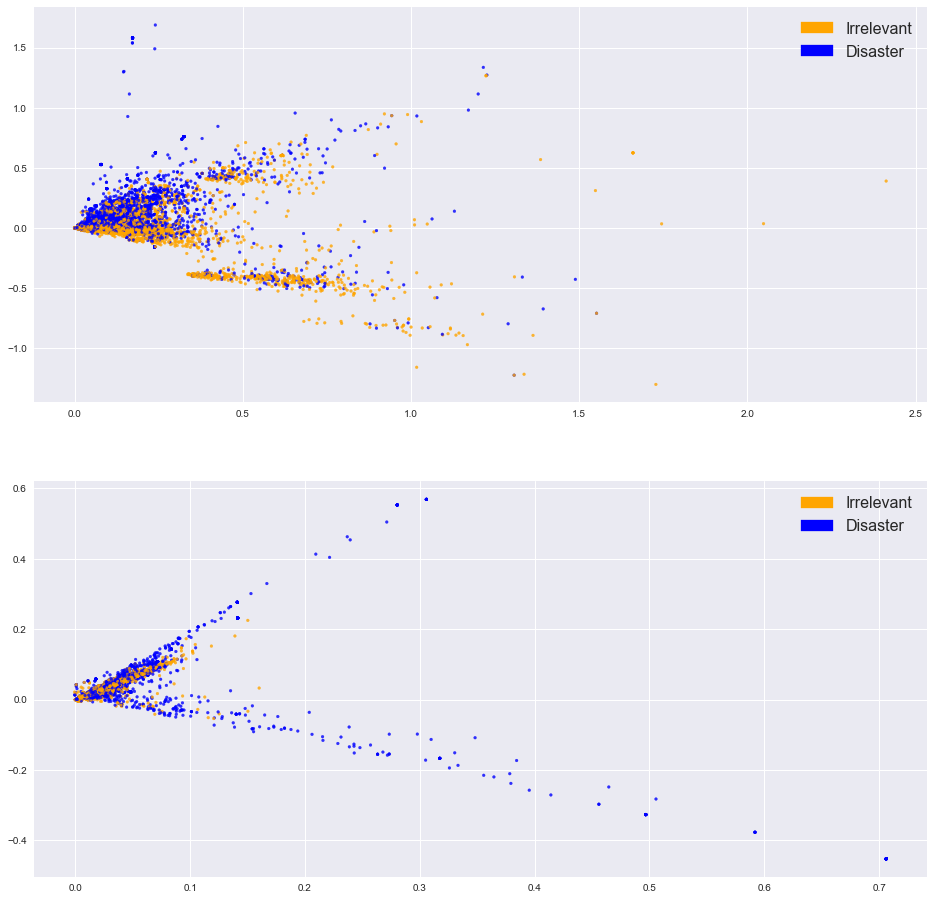

<IPython.core.display.Javascript object>

In [57]:
plt.figure(1, figsize=(16, 16))
plt.subplot(2, 1, 1)
plot_LSA(X_counts, y)
plt.subplot(2, 1, 2)
plot_LSA(X_tfidf, y)

TF IDF in this situation has better linearly separable classes.

### Basic Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

<IPython.core.display.Javascript object>

#### With CountVectorizer

In [47]:
X = train_counts
y = train["target"].values

X_train_counts, X_test, y_train_counts, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2020
)

<IPython.core.display.Javascript object>

In [48]:
model = LogisticRegression(class_weight="balanced")
model.fit(X_train_counts, y_train_counts)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

In [49]:
y_pred = model.predict(X_test)

f1score = f1_score(y_test, y_pred)
print(f"Counts Model Score: {f1score * 100} %")

Counts Model Score: 75.9170653907496 %


<IPython.core.display.Javascript object>

#### With TfidfVectorizer

In [50]:
X = train_tfidf
y = train["target"].values

X_train_tfidf, X_test, y_train_tfidf, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2020
)

<IPython.core.display.Javascript object>

In [51]:
model = LogisticRegression(class_weight="balanced")
model.fit(X_train_tfidf, y_train_tfidf)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

In [52]:
y_pred = model.predict(X_test)

f1score = f1_score(y_test, y_pred)
print(f"Tfidf Model Score: {f1score * 100} %")

Tfidf Model Score: 76.09756097560975 %


<IPython.core.display.Javascript object>

TF IDF has clearly better linearly separable classes, as shown in the increased f1 score.